#  Taxi orders prediction

The company has historical data on taxi orders at airports. To attract more drivers during the peak period, company needs a model, which can predict number of orders.
Main task: to build a model for predicting a taxi orders for the next hour.

The client's target metric *RMSE* on the test set must not exceed 48. The test set size is set to 10%.

## Data preprosesing and EDA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('/Users/andreyshagin/Downloads/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Sort by index, index contains time.
Perform resampling for 1 hour, cause main target orders for next hour.

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Checking that time in index is ascending

In [6]:
display(data.head())
data.tail()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


Create day of the week column (because we have weekly seasonality) and hour (because there is hourly (daily) seasonality), year and month factors are not needed, since we predict an order for an hour, so to determine trends, this will not help.
The lag autoregression parameter to take into account previous events, I also add the rolling smoothing factor, an analogue of the trend, I set it for 24 hours.

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 72, 24)

Check that all factors included

In [8]:
data

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,126.0,163.0,152.0,234.0,179.0,160.0,189.0,94.0,111.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,136.0,126.0,163.0,152.0,234.0,179.0,160.0,189.0,94.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,55.0,136.0,126.0,163.0,152.0,234.0,179.0,160.0,189.0,168.041667


Delete all missing values after adding new columns

In [9]:
data.dropna(inplace = True)

In [10]:
data

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-04 00:00:00,75,6,0,43.0,63.0,48.0,83.0,30.0,68.0,49.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,53.750000
2018-03-04 01:00:00,60,6,1,75.0,43.0,63.0,48.0,83.0,30.0,68.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,50.083333
2018-03-04 02:00:00,26,6,2,60.0,75.0,43.0,63.0,48.0,83.0,30.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,48.083333
2018-03-04 03:00:00,42,6,3,26.0,60.0,75.0,43.0,63.0,48.0,83.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,48.125000
2018-03-04 04:00:00,27,6,4,42.0,26.0,60.0,75.0,43.0,63.0,48.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,47.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,126.0,163.0,152.0,234.0,179.0,160.0,189.0,94.0,111.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,136.0,126.0,163.0,152.0,234.0,179.0,160.0,189.0,94.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,55.0,136.0,126.0,163.0,152.0,234.0,179.0,160.0,189.0,168.041667


I am using a boxplot , the median is 78, and the maximum value is 462, this is clearly visible on the graph.
Values from 25 quantile to 75 in the range is from 54 to 108 taxi orders.
It can also be seen that there are quite a lot of outliers - probably these are all peak hours, it should be noticeable on the trend.

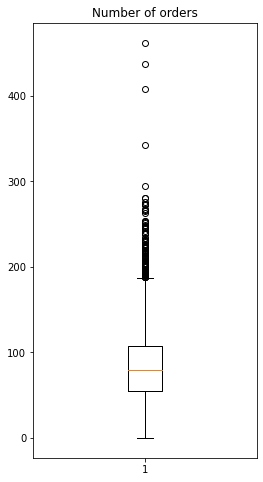

In [11]:
fig, ax = plt.subplots()
ax.set_title('Number of orders')
fig.set_size_inches(4, 8)
ax.boxplot(data['num_orders'])
plt.show()

In [12]:
data['num_orders'].describe()

count    4344.000000
mean       84.864411
std        45.084144
min         0.000000
25%        55.000000
50%        79.000000
75%       108.000000
max       462.000000
Name: num_orders, dtype: float64

Check for missing values and duplicates

In [14]:
data.isna().sum()

num_orders      0
dayofweek       0
hour            0
lag_1           0
lag_2           0
               ..
lag_69          0
lag_70          0
lag_71          0
lag_72          0
rolling_mean    0
Length: 76, dtype: int64

In [15]:
data.duplicated().sum()

0

Decompose the data to see the overall dynamics, it is noticeable that the demand for taxis is growing, this may be a seasonal phenomenon, for example, from winter to summer, but this could only be verified with data for several years.

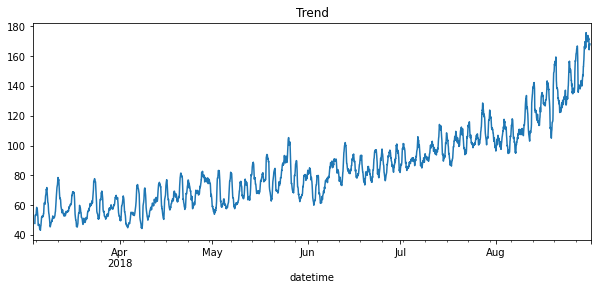

In [16]:
decomposed = seasonal_decompose(data['num_orders']) 

plt.figure(figsize=(10, 4))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()

Next, I look at the trend by the hour in the middle of the day, for this I take a period of three days from March 5 - this is Monday in 2018.
The trend is very similar: at 2-3 a.m. orders decrease, in the morning there is a noticeable drawdown, with the start of working hours at 8-9 a.m. orders increase, in the evening at 4 p.m. there is another peak, then growth begins at 6 p.m. and reaches its maximum n midnight.
I also built another chart for 2 days off to check this, the trend is similar.

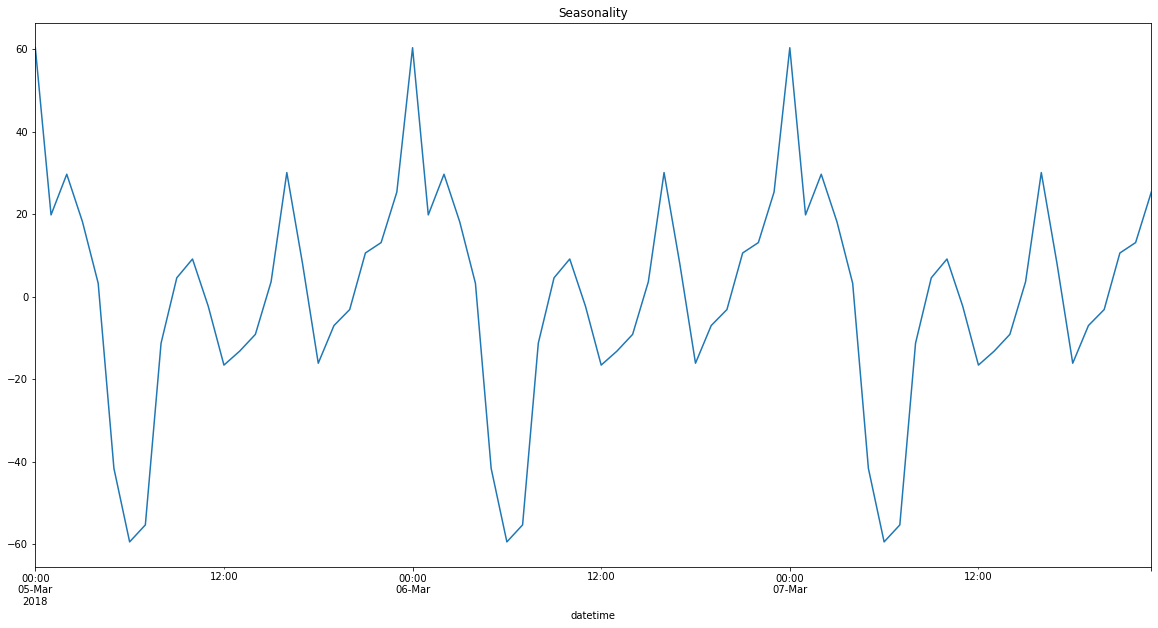

In [17]:
plt.figure(figsize=(20, 10))
decomposed.seasonal['2018-03-05':'2018-03-7'].plot(ax=plt.gca())
plt.title('Seasonality');

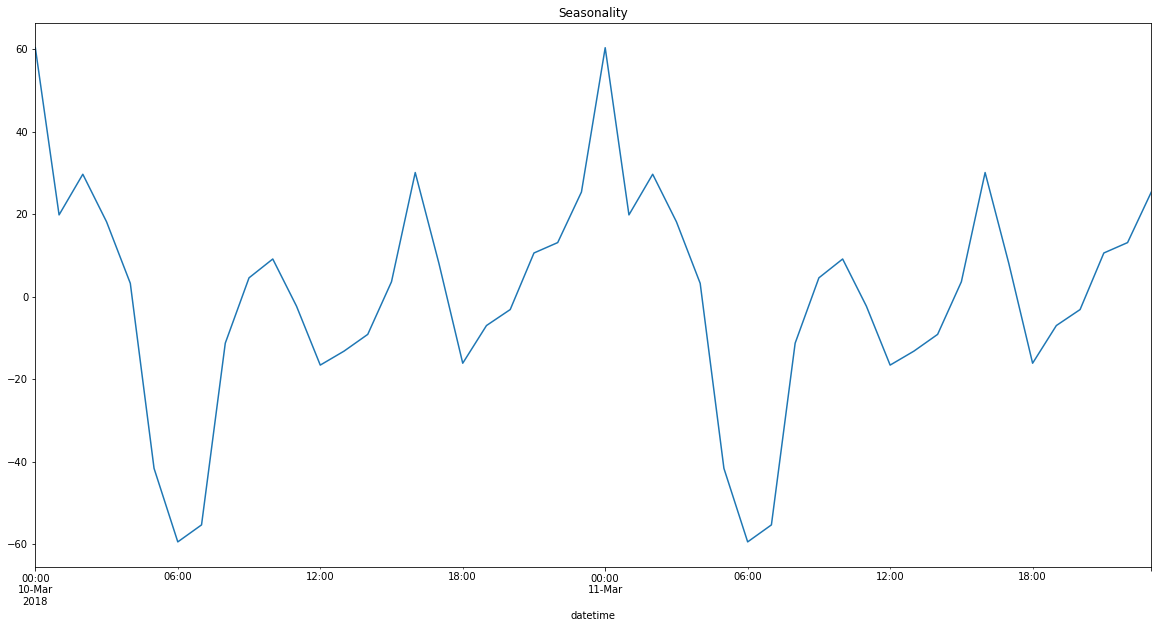

In [18]:
plt.figure(figsize=(20, 10))
decomposed.seasonal['2018-03-10':'2018-03-11'].plot(ax=plt.gca())
plt.title('Seasonality');

Make a plot by day, for this I do resampling by day.
Start date March 5 is Monday for 2 weeks.
On Monday the peak, due to night orders, on Tuesday there is a clear decrease in the number of orders on the 6th and 13th. On Wednesday, the largest number of orders could be attributed to the March 8 holiday, but on March 15 the situation is the same.
On Saturday, the number of orders decreases and rises by Sunday night.

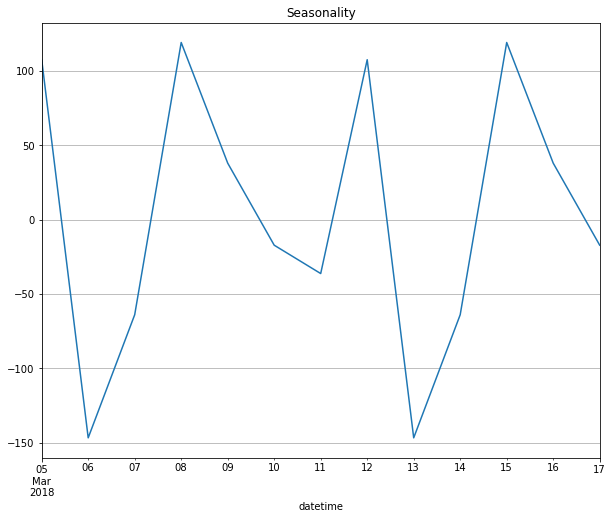

In [19]:
plt.figure(figsize=(10, 8))
data_day = data['2018-01':'2018-03'].resample('1D').sum() 
decomposed_day = seasonal_decompose(data_day['num_orders']) 
decomposed_day.seasonal['2018-03-05':'2018-03-17'].plot(ax=plt.gca())
plt.title('Seasonality');
plt.grid()
plt.show()

## Training

In [20]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

Split into train/valid/test subsets in proportion 80/10/10

In [21]:
features_train, features_valid_1, target_train, target_valid_1 = train_test_split(
    features, target, test_size=0.20, random_state=42, shuffle=False)

In [22]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_1, target_valid_1, test_size=0.50, random_state=42, shuffle=False)

In [23]:
features_test.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 21:00:00,0,21,82.0,91.0,104.0,152.0,144.0,175.0,102.0,119.0,...,55.0,126.0,171.0,175.0,226.0,249.0,162.0,188.0,143.0,141.500000
2018-08-13 22:00:00,0,22,160.0,82.0,91.0,104.0,152.0,144.0,175.0,102.0,...,56.0,55.0,126.0,171.0,175.0,226.0,249.0,162.0,188.0,142.541667
2018-08-13 23:00:00,0,23,104.0,160.0,82.0,91.0,104.0,152.0,144.0,175.0,...,33.0,56.0,55.0,126.0,171.0,175.0,226.0,249.0,162.0,141.958333
2018-08-14 00:00:00,1,0,134.0,104.0,160.0,82.0,91.0,104.0,152.0,144.0,...,106.0,33.0,56.0,55.0,126.0,171.0,175.0,226.0,249.0,139.833333
2018-08-14 01:00:00,1,1,139.0,134.0,104.0,160.0,82.0,91.0,104.0,152.0,...,120.0,106.0,33.0,56.0,55.0,126.0,171.0,175.0,226.0,138.958333


Train Linear Regression

In [24]:
LRmodel = LinearRegression()

In [25]:
LRmodel.fit(features_train, target_train)

LinearRegression()

In [26]:
LR_pred = LRmodel.predict(features_valid)
RMSE_LR = mean_squared_error (target_valid, LR_pred, squared= False)
RMSE_LR

30.716685983231393

RMSE 30, suit client target of RMSE 48

Train RandomForestRegressor

In [27]:
RFmodel = RandomForestRegressor (random_state=42, n_estimators=15, max_depth = 20)

In [28]:
RFmodel.fit (features_train, target_train)

RandomForestRegressor(max_depth=20, n_estimators=15, random_state=42)

In [29]:
RF_pred = RFmodel.predict(features_valid)
RMSE_RF = mean_squared_error (target_valid, RF_pred, squared= False)
RMSE_RF

32.32629774348561

RMSE turned out to be 32, which is below the target, I'm trying to make an improvement through the selection of hyperparameters in the cycle.

In [30]:
best_depth = 0
best_n_estimators = 0
best_rmse = 100

for depth in range(15, 26, 5):
    for estimators in range(10, 101, 10):
        RFmodel1 = RandomForestRegressor(random_state=42, n_estimators=estimators, max_depth=depth)
        RFmodel1.fit(features_train, target_train)
        RFmodel1_pred = RFmodel1.predict(features_valid)
        RMSE_RF1 = mean_squared_error(target_valid, RFmodel1_pred, squared= False)

        if RMSE_RF1 < best_rmse:
            best_rmse = RMSE_RF1
            best_depth = depth
            best_est = estimators

best_rmse

31.329871352476633

RMSE improved, but not mush, I'll try Catboost

Train first model Catboost

In [31]:
Cat_model = CatBoostRegressor(verbose = 100,
                              random_seed=42)

In [32]:
Cat_model.fit(features_train, target_train)

Learning rate set to 0.049848
0:	learn: 34.8915577	total: 58.2ms	remaining: 58.1s
100:	learn: 19.3804426	total: 531ms	remaining: 4.72s
200:	learn: 17.2484717	total: 881ms	remaining: 3.5s
300:	learn: 15.6583734	total: 1.26s	remaining: 2.92s
400:	learn: 14.3007013	total: 1.64s	remaining: 2.45s
500:	learn: 13.1238257	total: 2.02s	remaining: 2.01s
600:	learn: 12.1028046	total: 2.37s	remaining: 1.57s
700:	learn: 11.0957350	total: 2.74s	remaining: 1.17s
800:	learn: 10.2090320	total: 3.1s	remaining: 770ms
900:	learn: 9.4375273	total: 3.45s	remaining: 379ms
999:	learn: 8.7630026	total: 3.8s	remaining: 0us


In [33]:
Cat_pred = Cat_model.predict(features_valid)
RMSE_cat = mean_squared_error(target_valid, Cat_pred, squared= False)
RMSE_cat

30.226652635163475

RMSE turned out to be 30, below the target, comparable to the Linear Regression model, I'm trying to adjust the parameters to improve.

In [34]:
Cat_model2 = CatBoostRegressor()


In [35]:
tscv = TimeSeriesSplit(n_splits=3)
param_search = {'depth'         : [3,5,7],
                 'learning_rate' : [0.05, 0.03, 0.01],
                  'iterations'    : [1000],
                'verbose': [200],
                'early_stopping_rounds': [200],
                'random_seed':[42]
                 }
gsearch = GridSearchCV(estimator=Cat_model2, cv=tscv, param_grid=param_search)
gsearch.fit(features_train, target_train)

0:	learn: 28.7909270	total: 1.57ms	remaining: 1.57s
200:	learn: 14.6938641	total: 191ms	remaining: 759ms
400:	learn: 11.7895518	total: 349ms	remaining: 522ms
600:	learn: 9.8710010	total: 500ms	remaining: 332ms
800:	learn: 8.4734619	total: 660ms	remaining: 164ms
999:	learn: 7.2636069	total: 845ms	remaining: 0us
0:	learn: 30.8042669	total: 1.9ms	remaining: 1.9s
200:	learn: 16.9056664	total: 201ms	remaining: 799ms
400:	learn: 14.6322167	total: 392ms	remaining: 586ms
600:	learn: 13.0732062	total: 588ms	remaining: 390ms
800:	learn: 11.8966969	total: 781ms	remaining: 194ms
999:	learn: 10.8637360	total: 981ms	remaining: 0us
0:	learn: 32.6617059	total: 1.37ms	remaining: 1.37s
200:	learn: 18.2960194	total: 226ms	remaining: 897ms
400:	learn: 16.4556738	total: 447ms	remaining: 668ms
600:	learn: 15.0816489	total: 691ms	remaining: 459ms
800:	learn: 13.9998863	total: 919ms	remaining: 228ms
999:	learn: 13.0339099	total: 1.15s	remaining: 0us
0:	learn: 29.0365971	total: 1.57ms	remaining: 1.57s
200:	lea

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x124c07ac0>,
             param_grid={'depth': [3, 5, 7], 'early_stopping_rounds': [200],
                         'iterations': [1000],
                         'learning_rate': [0.05, 0.03, 0.01],
                         'random_seed': [42], 'verbose': [200]})

In [36]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gsearch.best_estimator_)
print("\n The best score across ALL searched params:\n",gsearch.best_score_)
print("\n The best parameters across ALL searched params:\n",gsearch.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.5526758459716751

 The best parameters across ALL searched params:
 {'depth': 5, 'early_stopping_rounds': 200, 'iterations': 1000, 'learning_rate': 0.03, 'random_seed': 42, 'verbose': 200}


In [37]:
Cat_model3 = CatBoostRegressor(iterations=1000,
                          learning_rate=0.03,
                          depth=5,
                         verbose = 100,
                              random_seed=42)

In [38]:
Cat_model3.fit(features_train, target_train)

0:	learn: 35.2343721	total: 6.41ms	remaining: 6.4s
100:	learn: 21.1579062	total: 318ms	remaining: 2.83s
200:	learn: 19.5569295	total: 621ms	remaining: 2.47s
300:	learn: 18.5357571	total: 901ms	remaining: 2.09s
400:	learn: 17.6279913	total: 1.16s	remaining: 1.74s
500:	learn: 16.7883790	total: 1.46s	remaining: 1.46s
600:	learn: 16.0982376	total: 1.74s	remaining: 1.15s
700:	learn: 15.4815322	total: 2.04s	remaining: 871ms
800:	learn: 14.8874729	total: 2.38s	remaining: 592ms
900:	learn: 14.3539003	total: 2.71s	remaining: 297ms
999:	learn: 13.8272720	total: 3s	remaining: 0us


In [39]:
Cat_pred3 = Cat_model3.predict(features_valid)
RMSE_cat3 = mean_squared_error(target_valid, Cat_pred3, squared= False)
RMSE_cat3

30.65189569445424

## Testing

I test Linear Regression, CatBoost Regressor and Random Forest models.

In [40]:
pred_test = LRmodel.predict(features_test)
RMSE_test = mean_squared_error(target_test, pred_test, squared= False)
RMSE_test

41.74006968960917

In [46]:
pred_test2 = Cat_model3.predict(features_test)
RMSE_test2 = mean_squared_error(target_test, pred_test2, squared= False)
RMSE_test2

46.7183898365124

In [42]:
pred_test3 = RFmodel1.predict(features_test)
RMSE_test3 = mean_squared_error(target_test, pred_test3, squared= False)
RMSE_test3

47.37865724010707

Make final table with all results

In [43]:
LinearRegression = {'RMSE': RMSE_LR}
RandomForestRegressor = {'RMSE': RMSE_RF}
RandomForestRegressor_tuned = {'RMSE': best_rmse}
CatBoostRegressor = {'RMSE': RMSE_cat}
CatBoostRegressor_tuned = {'RMSE': RMSE_cat3}
CatBoostRegressor_test = {'RMSE': RMSE_test2}
LinearRegression_test = {'RMSE': RMSE_test}

The best result for the model is Linear regression - 41, CatBoost with selected parameters on the test sample, the result is 46 - meets the customer's requirement - RMSE is less than 48.

In [44]:
Summary_table = pd.DataFrame([LinearRegression, RandomForestRegressor, RandomForestRegressor_tuned, CatBoostRegressor, CatBoostRegressor_tuned,CatBoostRegressor_test,LinearRegression_test],
                     index=['LinearRegression', 'RandomForestRegressor', 'RandomForestRegressor_tuned', 'CatBoostRegressor', 'CatBoostRegressor_tuned', 'CatBoostRegressor_test', 'LinearRegression_test'])
Summary_table


,RMSE
LinearRegression,30.716686
RandomForestRegressor,32.326298
RandomForestRegressor_tuned,31.329871
CatBoostRegressor,30.226653
CatBoostRegressor_tuned,30.651896
CatBoostRegressor_test,46.718390
LinearRegression_test,41.740070


# Conclusion

The following steps were taken for the project:

Data loaded, checked for mising values, duplicates.
An analysis was carried out to determine trends by hours during the day and by days. There are clear trends - a lot of orders on Sunday night rolling over to Monday, a drawdown on Tuesday, an increase on Wednesday and a further increase by Friday. There is also a trend by the hour inside the day - a lot of orders at night until 2-3 o'clock, then a decrease in demand, growth at 8-9 in the morning, stabilization and further two peaks around 16 o'clock and the largest by night.

Models were trained and predicted with default parameters and additionally using different sets of hyperparameters.
The best model was selected according to the results of the RMSE metric.

The best model with an RMSE score of 41 on the test sample - LinearRegression, a score below the target of 48.

Based on this, the general recommendation is:

To solve the problem of predicting the demand for a taxi an hour ahead, use the LinearRegression model.